In [ ]:
# BrainNetCNN Implementation


import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Dropout, Layer, Activation, LeakyReLU, ReLU
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2
from datetime import datetime
# Load the TensorBoard notebook extension.
%load_ext tensorboard
import cv2
from sklearn import metrics
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from google.colab import files

from sklearn.metrics import normalized_mutual_info_score, homogeneity_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    c_matrix = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(c_matrix, axis=0)) / np.sum(c_matrix)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

import sys
sys.path.append('/content/drive/My Drive')

Mounted at /content/drive


In [ ]:
cortical_thickness = pd.read_csv('/content/drive/My Drive/Cortical_Thickness.csv')
groundTruth = []
patients = {}
graphs = []

for filename in os.listdir("/content/drive/My Drive/NetworkData"):
    newName = filename.split("_",1)[0]
    currentPatientIndex = cortical_thickness.loc[cortical_thickness["SCANINDEX"] == newName]["PTINDEX"].values[0]
    currentLabel = cortical_thickness.loc[cortical_thickness["SCANINDEX"] == newName]["DX"].values[0]
    
    if currentLabel == "CN"  or currentLabel == "SMC" or currentLabel == "EMCI" or currentLabel == "LMCI" or currentLabel == "AD":
      if currentLabel == "CN" or currentLabel == "SMC":
        currentLabel = [1,0,0]
      elif currentLabel == "EMCI" or currentLabel == "LMCI":
        currentLabel = [0,1,0]
      elif currentLabel == "AD" :
        currentLabel = [0,0,1]

      adjacencyMatrix = np.loadtxt("/content/drive/My Drive/NetworkData/" + filename, dtype = 'int')
      adjacencyMatrix = adjacencyMatrix/adjacencyMatrix.max()
      
      #Multimodal integration along diagonal of adjacency matrix
      nodeAttributes = []
      for i in range(148):
          nodeAttribute = round(cortical_thickness.loc[cortical_thickness["SCANINDEX"] == newName]["Node " + str(i + 1)].values[0],3)
          nodeAttributes.append(nodeAttribute)
      nodeAttributes = np.asarray(nodeAttributes)
      nodeAttributes = (nodeAttributes)/nodeAttributes.max()
      for i in range(148):
        adjacencyMatrix[i][i] = nodeAttributes[i]

      adjacencyMatrix = tf.convert_to_tensor(adjacencyMatrix)
    
      if not currentPatientIndex in patients:
        patients[currentPatientIndex] = []
      
      visCode = cortical_thickness.loc[cortical_thickness["SCANINDEX"] == newName]["VISCODE"].values[0]
      patients[currentPatientIndex].append([adjacencyMatrix, currentLabel, visCode, currentPatientIndex])

In [ ]:
patients

In [ ]:

patientList = []

for key in patients:
  patientList.append(patients[key])

In [ ]:
choosePatients = []
for i in range(len(patientList)):
  if len(patientList[i]) >= 4:
    choosePatients.append(i)

In [ ]:
patientIDs = []
for i in choosePatients:
  patientIDs.append(list(patients.keys())[i])

In [ ]:
# Sorting by viscode

from operator import itemgetter
for i in range(len(patientList)):
  patientList[i]
  patientList[i] = sorted(patientList[i], key=itemgetter(2))

In [ ]:
#Characteristic Label for enhanced stratification
characteristicLabels = []
for patient in patientList:
  zeroCounter = 0
  oneCounter = 0
  for scan in patient:
    if scan[1] == 0:
      zeroCounter+=1
    else:
      oneCounter+=1
  if oneCounter > zeroCounter:
    characteristicLabels.append(1)
  else:
    characteristicLabels.append(0)


In [ ]:
# N2G right after E2N is equivalent to FC/dense layer

In [ ]:
class E2N(tf.keras.layers.Layer):
  def __init__(self, filters):
    super(E2N, self).__init__()
    self.filters = filters 
    
    self.conv_1xd = tf.keras.layers.Conv2D(self.filters, (1, 148))
    self.conv_dx1 = tf.keras.layers.Conv2D(self.filters, (148, 1))
    
    
  def call(self, input):
    dx1Output = self.conv_dx1(input)
    dx1Output = tf.reshape(dx1Output, [tf.shape(input)[0], 148, 1, self.filters])

    xdOutput = self.conv_1xd(input)
    xdOutput = tf.reshape(xdOutput, [tf.shape(input)[0], 148, 1, self.filters])
    
    return tf.math.add(dx1Output, xdOutput)


In [ ]:
class E2E(tf.keras.layers.Layer):
  def __init__(self, filters, input_shape):
    super(E2E, self).__init__()
    self.filters = filters 
    #self.input_shapes = inputs
    
    self.conv_1xd = tf.keras.layers.Conv2D(self.filters, (1, 148), input_shape = input_shape)
    self.conv_dx1 = tf.keras.layers.Conv2D(self.filters, (148 , 1), input_shape = input_shape)
    
  def call(self, input):
    #Creating dxd matrices
    xdOutput = self.conv_1xd(input)
    b = tf.constant([1, 1, 148, 1])
    conv_1xd_dxd = tf.tile(xdOutput, b)
    
    dx1Output = self.conv_dx1(input)
    c = tf.constant([1, 148, 1, 1])
    conv_dx1_dxd = tf.tile(dx1Output, c)

    return tf.math.add(conv_1xd_dxd, conv_dx1_dxd)

In [ ]:
class N2G(tf.keras.layers.Layer):
  def __init__(self, filters):
    super(N2G, self).__init__()
    self.filters = filters 

    self.conv_1xd = tf.keras.layers.Conv2D(self.filters, (148, 1))
    
  def call(self, input):
    return self.conv_1xd(input)

In [ ]:
def train_fold(model, train_graphs, train_labels, test_graphs, test_labels, epochs):
  logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
  history = model.fit(
      x = train_graphs, y = train_labels, epochs=epochs, verbose=1, validation_data=(test_graphs, test_labels), callbacks = [tensorboard_callback])
  
  # calculate performance on the test data and return along with history
  test_metrics = model.evaluate(test_graphs, test_labels, verbose=0)
  test_acc = test_metrics[model.metrics_names.index("accuracy")]
  test_auc = test_metrics[model.metrics_names.index("auc")]
  return history, test_acc, test_auc
  #test_precision = test_metrics[model.metrics_names.index("precision")]
  #test_sens = test_metrics[model.metrics_names.index("specificity_at_sensitivity_1")]
  #test_spec = test_metrics[model.metrics_names.index("sensitivity_at_specificity_3")]



In [ ]:
epochs = 1000

test_accs = []
test_aucs = []
svm_accs = []
svm_aucs = []
heatmaps = []

from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits=2, shuffle = True).split(characteristicLabels, characteristicLabels)

for i, (train_index, test_index) in enumerate(folds):
  filters1 = 8
  filters2 = 8
  filters3 = 28
  filters4 = 14

  model = tf.keras.Sequential()
  model.add(Input((148,148,1)))
  model.add(E2E(filters1, input_shape = (None, 148, 148, 1)))
  model.add(LeakyReLU(alpha=0.1))
  #model.add(ReLU())
  model.add(Dropout(0.3))
  model.add(E2N(filters2))
  model.add(LeakyReLU(alpha=0.1))
  #model.add(ReLU())
  model.add(Dropout(0.3))
  model.add(N2G(filters2))
  model.add(LeakyReLU(alpha=0.1))
  #model.add(ReLU())
  model.add(Dropout(0.3))
  model.add(Dense(filters3, activation='tanh'))
  model.add(Dropout(0.4))
  model.add(Dense(filters4, activation='tanh'))
  model.add(Dense(3, activation='softmax'))

  print(f"Training and evaluating on fold {i+1} out of {folds}...")
  trainGraphs = []
  trainLabels = []
  testGraphs = []
  testLabels = []
  for k in train_index:
    for j in range(len(patientList[k])):
      graph = patientList[k][j][0]
      graph = tf.reshape(graph, [1, 148,148,1])
      label = patientList[k][j][1]
      label = tf.constant(label)
      trainGraphs.append(graph)
      trainLabels.append(label)
  for k in test_index:
    for j in range(len(patientList[k])):
      graph = patientList[k][j][0]
      graph = tf.reshape(graph, [1, 148,148,1])
      label = patientList[k][j][1]
      label = tf.constant(label)
      testGraphs.append(graph)
      testLabels.append(label)
    
  trainGraphs = tf.reshape(trainGraphs, [len(trainGraphs), 148, 148, 1])
  trainLabels = tf.reshape(trainLabels, [len(trainGraphs), 1, 1, 3])
  testGraphs = tf.reshape(testGraphs, [len(testGraphs), 148, 148, 1])
  testLabels = tf.reshape(testLabels, [len(testGraphs), 1, 1, 3])

  opt = keras.optimizers.Adam(learning_rate=0.00001)
  model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy', 'AUC'])

  history, acc, auc = train_fold(model, trainGraphs, trainLabels, testGraphs, testLabels, epochs)

  test_accs.append(acc)
  test_aucs.append(auc)
  #heatmaps.append(heatmap)


Training and evaluating on fold 1 out of <generator object _BaseKFold.split at 0x7f5ba36a18e0>...
Epoch 1/1000
9/9 [==============================] - 1s 91ms/step - loss: 1.0991 - accuracy: 0.3707 - auc: 0.5119 - val_loss: 1.0973 - val_accuracy: 0.4776 - val_auc: 0.5459
Epoch 2/1000
9/9 [==============================] - 0s 22ms/step - loss: 1.0991 - accuracy: 0.3707 - auc: 0.4888 - val_loss: 1.0970 - val_accuracy: 0.4571 - val_auc: 0.5949
Epoch 3/1000
9/9 [==============================] - 0s 20ms/step - loss: 1.1008 - accuracy: 0.2973 - auc: 0.4546 - val_loss: 1.0967 - val_accuracy: 0.4776 - val_auc: 0.6092
Epoch 4/1000
9/9 [==============================] - 0s 20ms/step - loss: 1.0994 - accuracy: 0.3050 - auc: 0.4844 - val_loss: 1.0965 - val_accuracy: 0.4898 - val_auc: 0.6122
Epoch 5/1000
9/9 [==============================] - 0s 20ms/step - loss: 1.0973 - accuracy: 0.3668 - auc: 0.5261 - val_loss: 1.0962 - val_accuracy: 0.4776 - val_auc: 0.6192
Epoch 6/1000
9/9 [===================

KeyboardInterrupt: ignored

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e2e_10 (E2E)                 (None, 148, 148, 8)       2384      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 148, 148, 8)       0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 148, 148, 8)       0         
_________________________________________________________________
e2n_10 (E2N)                 (None, 148, 1, 8)         18960     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 148, 1, 8)         0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 148, 1, 8)         0         
_________________________________________________________________
n2g_10 (N2G)                 (None, 1, 1, 8)         

In [ ]:
y_score = model.predict(testGraphs)
y_true = testLabels

class0 = []
class1 = []
class2 = []
for i in y_score:
  class0.append(i[0][0][0])
  class1.append(i[0][0][1])
  class2.append(i[0][0][2])

class0T = []
class1T = []
class2T = []
for i in y_true.numpy():
  class0T.append(i[0][0][0])
  class1T.append(i[0][0][1])
  class2T.append(i[0][0][2])


In [ ]:
fpr0GCN = [0.     , 0.03125, 0.03125, 0.09375, 0.09375, 0.15625, 0.15625,
       0.1875 , 0.1875 , 0.21875, 0.21875, 0.25   , 0.25   , 0.3125 ,
       0.3125 , 0.375  , 0.375  , 0.4375 , 0.4375 , 0.5    , 0.5    ,
       0.5625 , 0.5625 , 0.59375, 0.59375, 0.65625, 0.65625, 0.6875 ,
       0.6875 , 0.71875, 0.71875, 0.78125, 0.78125, 0.9375 , 0.9375 ,
       1.     ]
tpr0GCN = [0.        , 0.        , 0.03030303, 0.03030303, 0.06060606,
       0.06060606, 0.15151515, 0.15151515, 0.21212121, 0.21212121,
       0.24242424, 0.24242424, 0.27272727, 0.27272727, 0.57575758,
       0.57575758, 0.60606061, 0.60606061, 0.63636364, 0.63636364,
       0.66666667, 0.66666667, 0.75757576, 0.75757576, 0.78787879,
       0.78787879, 0.84848485, 0.84848485, 0.87878788, 0.87878788,
       0.90909091, 0.90909091, 0.93939394, 0.93939394, 1.        ,
       1.        ]
aucroc0GCN = 0.5899621212121212

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

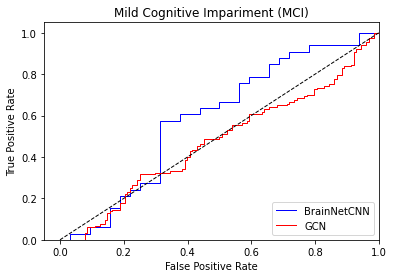

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[0], tpr[0], _ = roc_curve(class1T, class1)
roc_auc[0] = auc(fpr[0], tpr[0])
plt.plot(fpr0GCN, tpr0GCN, color='blue', lw=1,
             label='BrainNetCNN'
             ''.format(0, aucroc0GCN))
plt.plot(fpr[0], tpr[0], color='red', lw=1,
             label='GCN'
             ''.format(0, roc_auc[0]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Mild Cognitive Impariment (MCI)")
plt.legend(loc="lower right")

plt.savefig('CNROC.jpg', dpi = 500)
files.download("CNROC.jpg") 

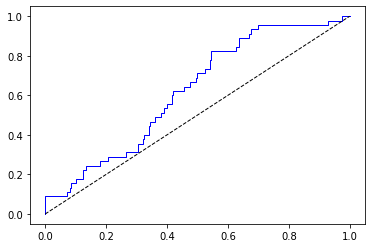

In [ ]:
fpr[1], tpr[1], _ = roc_curve(class2T, class2)
roc_auc[1] = auc(fpr[1], tpr[1])
plt.plot(fpr[1], tpr[1], color='blue', lw=1,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(1, roc_auc[1]))
plt.plot([0, 1], [0, 1], 'k--', lw=1)

In [ ]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)
print(
    f"AUC over all folds mean: {np.mean(test_aucs)*100:.3}% and std: {np.std(test_aucs)*100:.2}%"
)
print(
    f"Accuracy over all folds mean (SVM): {np.mean(svm_accs)*100:.3}% and std: {np.std(svm_accs)*100:.2}%"
)
print(
    f"AUC over all folds mean (SVM): {np.mean(svm_aucs)*100:.3}% and std: {np.std(svm_aucs)*100:.2}%"
)

Accuracy over all folds mean: 47.3% and std: 9.8%
AUC over all folds mean: 62.5% and std: 6.4%
Accuracy over all folds mean (SVM): nan% and std: nan%
AUC over all folds mean (SVM): nan% and std: nan%


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
%tensorboard --logdir logs/scalars

In [ ]:
patientList = np.asarray(patientList)

In [ ]:
# Collecting sets of 4 time points
patientList2 = []
for k in range(70):
  if len(patientList[k]) >= 4:
      patientList2.append(patientList[k][len(patientList[k])-4:])
for k in range(70, 141):
  if len(patientList[k]) >= 4:
      patientList2.append(patientList[k][:4])

In [ ]:
# Converting tensors to numpy arrays
for k in range(patientList.shape[0]):
    for j in range(len(patientList[k])):
      graph = patientList[k][j][0]
      graph = graph.numpy()
      patientList[k][j][0] = graph


AttributeError: ignored

In [ ]:
np.save('PatientData', patientList)

In [ ]:
trainOutputs = []
testOutputs = []

In [ ]:
# Extracting embeddings
featureExtractor = keras.Model(inputs=model.input,
                                        outputs=model.layers[7].output)

for i in trainGraphs:
      graph = tf.reshape(i, [1,148,148,1])
      output = featureExtractor(graph)
      output = tf.reshape(output, (8,))
      trainOutputs.append(output)
for i in testGraphs:
     graph = tf.reshape(i, [1,148,148,1])
     output = featureExtractor(graph)
     output = tf.reshape(output, (8,))
     testOutputs.append(output)

In [ ]:
len(labels)

504

In [ ]:
np.save('PatientData', patientList)

In [ ]:
embeddings = np.concatenate((trainOutputs, testOutputs))

In [ ]:
labels = np.concatenate((trainLabels, testLabels))

In [ ]:
len(labels)

504

In [ ]:
labels[0][0][0

SyntaxError: ignored

In [ ]:
labels2 = []
for i in labels:
  if i[0][0][0] == 1:
    labels2.append(0)
  elif i[0][0][1] == 1:
    labels2.append(1)
  else:
    labels2.append(2)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(embeddings)
pred_y = kmeans.labels_


tmp_nmi    = normalized_mutual_info_score(labels2, pred_y)
tmp_ri     = adjusted_rand_score(labels2, pred_y)
tmp_purity = purity_score(labels2, pred_y)

print('NMI:{:.4f}, RI:{:.4f}, PURITY:{:.4f}'.format(tmp_nmi, tmp_ri, tmp_purity))

NMI:0.0747, RI:0.0377, PURITY:0.5020


In [ ]:
len(labels)

504

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(embeddings)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 504 samples in 0.003s...
[t-SNE] Computed neighbors for 504 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 504 / 504
[t-SNE] Mean sigma: 0.027614
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.054005
[t-SNE] KL divergence after 300 iterations: 0.323005


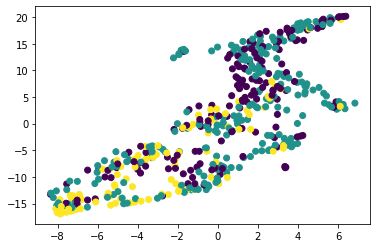

In [ ]:
cdict = {0: 'red', 1: 'blue', 2: 'green'}
plt.scatter(tsne_results[:,0], tsne_results[:,1], c = labels2)

In [ ]:
# PCA reduction of dimensions to 2
# Create a PCA instance: pca
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(embeddings)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

([<matplotlib.axis.XTick at 0x7f842669d898>,
 <a list of 5 Text major ticklabel objects>)

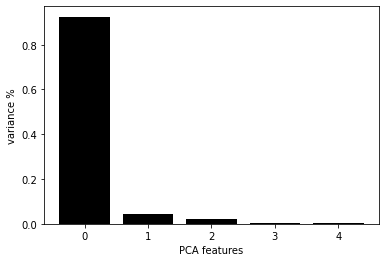

In [ ]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)


Text(0, 0.5, 'PCA 2')

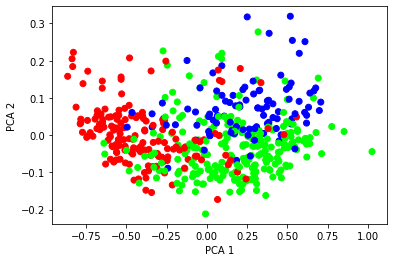

In [ ]:

plt.scatter(PCA_components[0], PCA_components[1], c = labels, cmap = cdict)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [ ]:
points = []
labels2 = []
for i in range(5):
  for j in range(len(patientList[i])):
    points.append(patientList[i][j][0])
    labels2.append(i)